# Environment Setup

In [ ]:
# =========================
# CELL 0.1 — Mount Drive + set working directory (persistent)
# =========================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Options Pricing Research (S26)/machine_learning_for_options_pricing_and_implied_volatility")
print("cwd =", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cwd = /content/drive/MyDrive/Options Pricing Research (S26)/machine_learning_for_options_pricing_and_implied_volatility


In [ ]:
# =========================
# CELL 0.2 — Installs (only if needed)
# QMC (Latin Hypercube) should exist on most SciPy versions; this upgrades only if missing.
# =========================
try:
    from scipy.stats import qmc
    import scipy
    print("scipy version:", scipy.__version__)
    print("qmc available ✅")
except Exception as e:
    print("qmc not available, upgrading scipy... error was:", repr(e))
    !pip -q install --upgrade scipy
    import scipy
    print("scipy version after upgrade:", scipy.__version__)
    from scipy.stats import qmc
    print("qmc available ✅")

scipy version: 1.16.3
qmc available ✅


In [ ]:
# =========================
# CELL 0.3 — Imports (your style + minimal extras)
# =========================

# Basic imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# QMC for Latin Hypercube Sampling
from scipy.stats import qmc

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, LinearLR, OneCycleLR, LambdaLR

# Utilities
import json, datetime, subprocess, os

In [ ]:
# =========================
# CELL 0.4 — Reproducibility (global seeds)
# =========================
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("SEED =", SEED)

SEED = 42


In [ ]:
# =========================
# CELL 0.5 — Run Logger (inline, saves everything to Drive under runs/)
# This is your "never rerun" system.
# =========================
def _git_hash():
    try:
        return subprocess.check_output(["git", "rev-parse", "HEAD"]).decode().strip()
    except Exception:
        return "no-git"

def start_run(task: str, base_dir="runs"):
    run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = os.path.join(base_dir, task, run_id)
    fig_dir = os.path.join(run_dir, "figures")
    os.makedirs(fig_dir, exist_ok=True)

    meta = {
        "task": task,
        "run_id": run_id,
        "created_at": datetime.datetime.now().isoformat(),
        "git_commit": _git_hash(),
        "seed": SEED,
    }
    with open(os.path.join(run_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    return run_dir, fig_dir

def save_json(run_dir: str, name: str, obj: dict):
    with open(os.path.join(run_dir, f"{name}.json"), "w") as f:
        json.dump(obj, f, indent=2)

def save_notes(run_dir: str, text: str):
    with open(os.path.join(run_dir, "notes.md"), "w") as f:
        f.write(text.strip() + "\n")

print("Logger ready ✅")

Logger ready ✅


# BS-ANN

In [ ]:
# =========================
# CELL 1.0 — Week 2 START (creates a run folder for this week)
# =========================
run_dir, fig_dir = start_run("week2_bsm_basics")
print("run_dir:", run_dir)
print("fig_dir:", fig_dir)

save_json(run_dir, "params", {
    "week": 2,
    "goal": "BSM formula basics + equivalence of scaled vs unscaled + 2 plots",
    "plotA": "fix (tau,r,sigma), vary m=S/K, plot V/K",
    "plotB": "fix (m,tau,r), vary sigma, plot V/K",
})

save_notes(run_dir, """
Week 2 deliverable:
- Explain variables S,K,tau,r,sigma and what a European call payoff is.
- Explain why bs_price_call(S,K,...) and bs_moneyness_call(m=S/K,...) are equivalent.
- Plot A: V/K vs m with fixed tau,r,sigma (tau>0).
- Plot B: V/K vs sigma with fixed m,tau,r.
""")

run_dir: runs/week2_bsm_basics/20260118-231325
fig_dir: runs/week2_bsm_basics/20260118-231325/figures


## Closed-Form Formula

In [ ]:
# =========================
# Week 2 — 1.1) BLACK–SCHOLES FORMULAE (PRICE + SCALED MONEYNESS VERSION)
# =========================

def bs_price_call(S, K, T, t, r, sigma):
  """
  Black-Sholes call option value price related to PDE (2). Returns option's price.
  S: spot price
  K: strike price
  T: time to maturity
  t: spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  # Boundary condition of Black-Sholes PDE (2)
  if T==t:
    return np.maximum(0,S-K)
  # Solution of the PDE (2) on the open interval [t, T)
  else :
    d1 = ( np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t) ) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    value = S * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)

  return value

def bs_moyeness_call(moyeness, tau, r, sigma):
  """
  Same function as bs_price_call but in terms of moyeness. Returns V/K and
  has S/K instead of two seperate paremeters S and K.
  moyeness: S/K
  Tau: time to maturity minus spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  d1 = ( np.log(moyeness) + (r + 0.5 * sigma ** 2) * (tau) ) / (sigma * np.sqrt(tau))
  d2 = d1 - sigma*np.sqrt(tau)
  value_moyeness = moyeness * norm.cdf(d1) - np.exp(-r * (tau)) * norm.cdf(d2)

  return value_moyeness

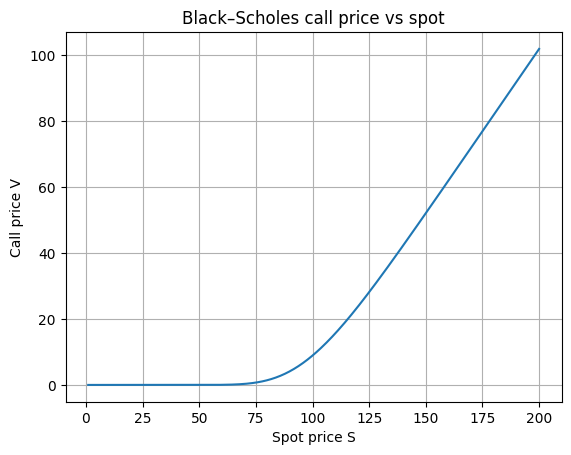

Saved: runs/week2_bsm_basics/20260118-231325/figures/plot0_price_vs_spot.png


In [ ]:
# =========================
# Week 2 — 1.2) VISUALIZATION: CALL PRICE AS A FUNCTION OF SPOT PRICE
# =========================

r, T, t, sigma, K = 0.02, 1.0, 0.0, 0.2, 100
S = np.linspace(1, 200, 400)

V = bs_price_call(S, K, T, t, r, sigma)

plt.figure()
plt.plot(S, V)
plt.xlabel("Spot price S")
plt.ylabel("Call price V")
plt.title("Black–Scholes call price vs spot")
plt.grid(True)

path = os.path.join(fig_dir, "plot0_price_vs_spot.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

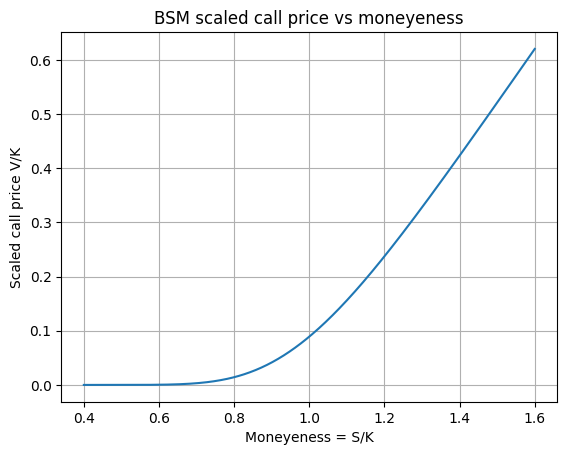

Saved: runs/week2_bsm_basics/20260118-231325/figures/plotA_VK_vs_moneyeness.png


In [ ]:
# =========================
# Week 2 — 1.3) PLOT A: SCALED CALL PRICE AS A FUNCTION OF MONEYNESS
# =========================

tau, r, sigma = 1.0, 0.02, 0.2
moneyeness = np.linspace(0.4, 1.6, 400)

vk = bs_moyeness_call(moneyeness, tau, r, sigma)

plt.figure()
plt.plot(moneyeness, vk)
plt.xlabel("Moneyeness = S/K")
plt.ylabel("Scaled call price V/K")
plt.title("BSM scaled call price vs moneyeness")
plt.grid(True)

path = os.path.join(fig_dir, "plotA_VK_vs_moneyeness.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

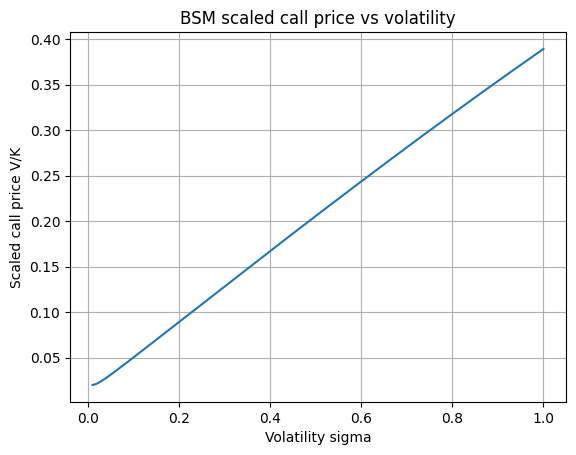

Saved: runs/week2_bsm_basics/20260118-231325/figures/plotB_VK_vs_sigma.png


In [ ]:
# =========================
# Week 2 — 1.4) PLOT B: SCALED CALL PRICE AS A FUNCTION OF VOLATILITY
# =========================

moyeness_fixed, tau, r = 1.0, 1.0, 0.02
sigmas = np.linspace(0.01, 1.0, 300)

vk2 = np.array([bs_moyeness_call(moyeness_fixed, tau, r, s) for s in sigmas])

plt.figure()
plt.plot(sigmas, vk2)
plt.xlabel("Volatility sigma")
plt.ylabel("Scaled call price V/K")
plt.title("BSM scaled call price vs volatility")
plt.grid(True)

path = os.path.join(fig_dir, "plotB_VK_vs_sigma.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

In [ ]:
# =========================
# Week 2 — 1.5) EQUIVALENCE CHECK: (bs_price_call / K) == bs_moyeness_call(S/K)
# =========================

S0, K0, T0, t0, r0, sigma0 = 110, 100, 1.0, 0.0, 0.02, 0.2
tau0 = T0 - t0

vk_from_price = bs_price_call(S0, K0, T0, t0, r0, sigma0) / K0
vk_from_m = bs_moyeness_call(S0 / K0, tau0, r0, sigma0)
diff = float(abs(vk_from_price - vk_from_m))

print("V/K from bs_price_call:", float(vk_from_price))
print("V/K from bs_moyeness_call:", float(vk_from_m))
print("abs diff:", diff)

save_json(run_dir, "equivalence", {
    "inputs": {"S": S0, "K": K0, "T": T0, "t": t0, "r": r0, "sigma": sigma0},
    "vk_from_price": float(vk_from_price),
    "vk_from_m": float(vk_from_m),
    "abs_diff": diff
})

V/K from bs_price_call: 0.1560884145071418
V/K from bs_moyeness_call: 0.15608841450714184
abs diff: 2.7755575615628914e-17


In [ ]:
# =========================
# Week 2 — 1.6) WEEK 2 SUMMARY
# =========================

summary = """
Week 2 Summary (BSM basics):
I implemented the Black–Scholes European call price in two equivalent forms. The first function bs_price_call uses absolute inputs (S, K, T, t) and returns the dollar option price V. The second function bs_moyeness_call uses moyeness m=S/K and time-to-maturity tau=T−t, and returns the scaled price V/K. These are equivalent because dividing the Black–Scholes formula by K and substituting S=mK cancels K throughout, leaving a function of (m, tau, r, sigma). I verified equivalence numerically by comparing bs_price_call(S,K,T,t,r,sigma)/K to bs_moyeness_call(S/K, tau, r, sigma) on a sample input. I also generated two diagnostic plots: (1) V/K as a function of moyeness for fixed (tau, r, sigma), and (2) V/K as a function of volatility for fixed (m, tau, r).
""".strip()

with open(os.path.join(run_dir, "notes_week2_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir, "notes_week2_summary.md"))
print("\n" + summary)

Saved summary to: runs/week2_bsm_basics/20260118-231325/notes_week2_summary.md

Week 2 Summary (BSM basics):
I implemented the Black–Scholes European call price in two equivalent forms. The first function bs_price_call uses absolute inputs (S, K, T, t) and returns the dollar option price V. The second function bs_moyeness_call uses moyeness m=S/K and time-to-maturity tau=T−t, and returns the scaled price V/K. These are equivalent because dividing the Black–Scholes formula by K and substituting S=mK cancels K throughout, leaving a function of (m, tau, r, sigma). I verified equivalence numerically by comparing bs_price_call(S,K,T,t,r,sigma)/K to bs_moyeness_call(S/K, tau, r, sigma) on a sample input. I also generated two diagnostic plots: (1) V/K as a function of moyeness for fixed (tau, r, sigma), and (2) V/K as a function of volatility for fixed (m, tau, r).


## Data Generation

In [ ]:
# =========================
# CELL 3.0 — Week 3 START (creates a run folder for this week)
# =========================
run_dir, fig_dir = start_run("week3_lhs_dataset_generation")
print("run_dir:", run_dir)
print("fig_dir:", fig_dir)

save_json(run_dir, "params", {
    "week": 3,
    "goal": "LHS dataset generation for BS-ANN (X=(m,tau,r,sigma), y=V/K) + sanity checks + 4 input histograms + data card",
    "n": 10**6,
    "inputs": {
        "col0 m = S/K": [0.4, 1.6],
        "col1 tau = T-t": [0.2, 1.1],
        "col2 r": [0.02, 0.10],
        "col3 sigma": [0.01, 1.0],
    },
    "label": "col4 V/K",
    "checks": [
        "m>0, tau>0, sigma>0",
        "0 <= V/K <= m",
    ],
    "artifacts": [
        "bs_lhs_dataset_n1e6.pt",
        "week3_LHS_input_histograms.png",
        "notes_week3_data_card.md",
    ],
})

save_notes(run_dir, """
Week 3 (Feb 2–6) — LHS dataset generation (for BS-ANN)

Knowledge
- Supervised learning needs: inputs X and labels y.
- Why Latin Hypercube Sampling (LHS):
  uniform coverage across each dimension
  fewer “clumps” than random sampling
- Dataset columns:
  col0: (S/K) = m
  col1: (tau)
  col2: (r)
  col3: (sigma)
  col4: (V/K) (label)

Do
- Generate n=1e6 using bs_LHS_data_generator.
- Sanity checks:
  ensure (S/K>0), (tau>0), (sigma>0)
  check bounds: (0 <= V/K <= S/K)
- Plot histograms of each input dimension (4 histograms).
- Friday deliverable: “data card” with ranges + histogram screenshot.
""")

run_dir: runs/week3_lhs_dataset_generation/20260119-190307
fig_dir: runs/week3_lhs_dataset_generation/20260119-190307/figures


In [ ]:
# =========================
# Week 3 — 3.1) LHS DATA GENERATOR (uses Week 2 bs_moyeness_call formula)
# =========================
def bs_LHS_data_generator(n=10**6):
    # ranges
    lo = np.array([0.4, 0.2, 0.02, 0.01])   # [m, tau, r, sigma]
    hi = np.array([1.6, 1.1, 0.10, 1.00])

    # LHS -> scale to ranges
    x = qmc.scale(qmc.LatinHypercube(d=4).random(n), lo, hi)
    m, tau, r, sigma = x[:, 0], x[:, 1], x[:, 2], x[:, 3]

    # label y = V/K (same closed-form as Week 2 bs_moyeness_call, vectorized)
    d1 = (np.log(m) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    vk = m * norm.cdf(d1) - np.exp(-r * tau) * norm.cdf(d2)

    # sanity checks
    assert np.all(m > 0), "Sanity check failed: S/K must be > 0"
    assert np.all(tau > 0), "Sanity check failed: tau must be > 0"
    assert np.all(sigma > 0), "Sanity check failed: sigma must be > 0"
    assert np.all(vk >= 0), "Sanity check failed: V/K must be >= 0"
    assert np.all(vk <= m + 1e-6), "Sanity check failed: V/K must be <= S/K"

    return torch.tensor(np.column_stack([m, tau, r, sigma, vk]), dtype=torch.float32)

In [ ]:
# =========================
# Week 3 — 3.2) GENERATE n=1e6 + SAVE DATASET
# =========================
n = 10**6
data = bs_LHS_data_generator(n)
print("Dataset shape:", tuple(data.shape))

dataset_path = os.path.join(run_dir, "bs_lhs_dataset_n1e6.pt")
torch.save(data, dataset_path)
print("Saved dataset:", dataset_path)

Dataset shape: (1000000, 5)
Saved dataset: runs/week3_lhs_dataset_generation/20260119-190307/bs_lhs_dataset_n1e6.pt


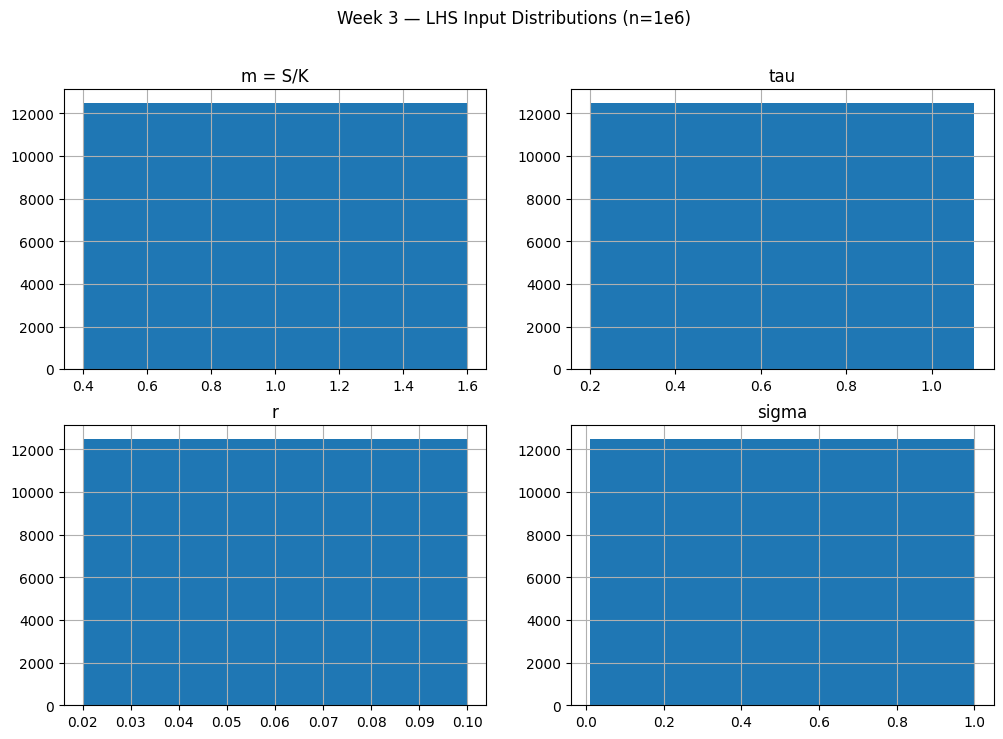

Saved: runs/week3_lhs_dataset_generation/20260119-190307/figures/week3_LHS_input_histograms.png


In [ ]:
# =========================
# Week 3 — 3.3) HISTOGRAMS (4 input dimensions) + SAVE FIGURE
# =========================
plt.figure(figsize=(12, 8))
for i, title in enumerate(["m = S/K", "tau", "r", "sigma"]):
    plt.subplot(2, 2, i + 1)
    plt.hist(data[:, i].numpy(), bins=80)
    plt.title(title)
    plt.grid(True)

plt.suptitle("Week 3 — LHS Input Distributions (n=1e6)")

hist_path = os.path.join(fig_dir, "week3_LHS_input_histograms.png")
plt.savefig(hist_path, dpi=180, bbox_inches="tight")
plt.show()
print("Saved:", hist_path)

In [ ]:
# =========================
# Week 3 — 3.4) DATA CARD (ranges + histogram screenshot reference)
# =========================
mins = data.min(dim=0).values.numpy()
maxs = data.max(dim=0).values.numpy()

data_card = f"""
Week 3 Data Card — LHS Dataset (BS-ANN)

n = {n}

Target ranges:
m (S/K):      [0.4, 1.6]
tau (T-t):    [0.2, 1.1]
r:            [0.02, 0.10]
sigma:        [0.01, 1.0]

Actual min/max (generated):
m (S/K):      [{mins[0]:.6f}, {maxs[0]:.6f}]
tau (T-t):    [{mins[1]:.6f}, {maxs[1]:.6f}]
r:            [{mins[2]:.6f}, {maxs[2]:.6f}]
sigma:        [{mins[3]:.6f}, {maxs[3]:.6f}]
V/K (label):  [{mins[4]:.6f}, {maxs[4]:.6f}]

Sanity checks enforced:
- S/K > 0, tau > 0, sigma > 0
- 0 <= V/K <= S/K

Histogram screenshot:
- {hist_path}

Saved dataset:
- {dataset_path}
""".strip()

with open(os.path.join(run_dir, "notes_week3_data_card.md"), "w") as f:
    f.write(data_card + "\n")

print("Saved data card to:", os.path.join(run_dir, "notes_week3_data_card.md"))
print("\n" + data_card)

Saved data card to: runs/week3_lhs_dataset_generation/20260119-190307/notes_week3_data_card.md

Week 3 Data Card — LHS Dataset (BS-ANN)

n = 1000000

Target ranges:
m (S/K):      [0.4, 1.6]
tau (T-t):    [0.2, 1.1]
r:            [0.02, 0.10]
sigma:        [0.01, 1.0]

Actual min/max (generated):
m (S/K):      [0.400000, 1.599999]
tau (T-t):    [0.200000, 1.100000]
r:            [0.020000, 0.100000]
sigma:        [0.010001, 1.000000]
V/K (label):  [0.000000, 0.900102]

Sanity checks enforced:
- S/K > 0, tau > 0, sigma > 0
- 0 <= V/K <= S/K

Histogram screenshot:
- runs/week3_lhs_dataset_generation/20260119-190307/figures/week3_LHS_input_histograms.png

Saved dataset:
- runs/week3_lhs_dataset_generation/20260119-190307/bs_lhs_dataset_n1e6.pt


In [ ]:
# =========================
# Week 3 — 3.5) WEEK 3 SUMMARY
# =========================

summary = f"""
Week 3 Summary (LHS dataset generation for BS-ANN):
I generated a supervised-learning dataset for the Black–Scholes scaled call pricing problem, where the inputs are X = (m, tau, r, sigma) with m = S/K and the label is y = V/K. To construct X with good coverage across the 4-dimensional domain, I used Latin Hypercube Sampling (LHS), which enforces near-uniform coverage in each dimension and avoids the clumping typical of naive random sampling. Using the Week 2 closed-form scaled Black–Scholes formula, I computed V/K for each sampled point and assembled a tensor of shape (n, 5) with columns [m, tau, r, sigma, V/K]. I enforced basic domain validity checks (m>0, tau>0, sigma>0) and a no-arbitrage bound check (0 <= V/K <= m, since 0 <= V <= S). I saved the final dataset (n = {10**6}) as a PyTorch tensor and produced a 2×2 histogram figure showing the empirical distributions of the four input dimensions; both artifacts were saved to the run folder and figures folder respectively. Finally, I wrote a “data card” summarizing the target parameter ranges, realized min/max in the generated data, and a reference to the histogram screenshot for documentation.
""".strip()

with open(os.path.join(run_dir, "notes_week3_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir, "notes_week3_summary.md"))
print("\n" + summary)

Saved summary to: runs/week3_lhs_dataset_generation/20260119-190307/notes_week3_summary.md

Week 3 Summary (LHS dataset generation for BS-ANN):
I generated a supervised-learning dataset for the Black–Scholes scaled call pricing problem, where the inputs are X = (m, tau, r, sigma) with m = S/K and the label is y = V/K. To construct X with good coverage across the 4-dimensional domain, I used Latin Hypercube Sampling (LHS), which enforces near-uniform coverage in each dimension and avoids the clumping typical of naive random sampling. Using the Week 2 closed-form scaled Black–Scholes formula, I computed V/K for each sampled point and assembled a tensor of shape (n, 5) with columns [m, tau, r, sigma, V/K]. I enforced basic domain validity checks (m>0, tau>0, sigma>0) and a no-arbitrage bound check (0 <= V/K <= m, since 0 <= V <= S). I saved the final dataset (n = 1000000) as a PyTorch tensor and produced a 2×2 histogram figure showing the empirical distributions of the four input dimensio